# <center>10.4 LSTM实战股票预测</center>

实验目的：该实验代码实现比较简单，利用Tensorflow2.x框架搭建循环神经网络中的LSTM模型，并对股票数据进行训练，最终实现根据过去的股票数据对未来趋势的预测。

# 1、导入需要的库

In [12]:
#import需要用到的库
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

In [13]:
#使用Tensorflow2.0版本
import tensorflow.keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, SpatialDropout1D, SimpleRNN, GRU, Flatten

# 2、读取股票数据

 首先读取股票数据集，股票数据集包括开盘价、收盘价、最高价、最低价等七个因素,对应的Y值为第二天的最高价

In [14]:
f=open('./stock_dataset_2.csv')  #股票数据集
df=pd.read_csv(f)          #用pandas打开csv格式的股票数据,返回一个DataFrame
df.head()

,index_code,date,open,close,low,high,volume,money,change,label
0,sh000001,1990/12/20,104.30,104.39,99.98,104.39,197000.0,85000.0,0.044109,109.13
1,sh000001,1990/12/21,109.07,109.13,103.73,109.13,28000.0,16100.0,0.045407,114.55
2,sh000001,1990/12/24,113.57,114.55,109.13,114.55,32000.0,31100.0,0.049666,120.25
3,sh000001,1990/12/25,120.09,120.25,114.55,120.25,15000.0,6500.0,0.049760,125.27
4,sh000001,1990/12/26,125.27,125.27,120.25,125.27,100000.0,53700.0,0.041746,125.28


In [15]:
data=df.iloc[:,2:10].values  #使用pandas的iloc读取股票的3到10列，.values返回一个numpy.ndarray,
data=data.astype('float32')
data

array([[ 1.0430000e+02,  1.0439000e+02,  9.9980003e+01, ...,
         8.5000000e+04,  4.4108823e-02,  1.0913000e+02],
       [ 1.0907000e+02,  1.0913000e+02,  1.0373000e+02, ...,
         1.6100000e+04,  4.5406647e-02,  1.1455000e+02],
       [ 1.1357000e+02,  1.1455000e+02,  1.0913000e+02, ...,
         3.1100000e+04,  4.9665537e-02,  1.2025000e+02],
       ...,
       [ 3.5186499e+03,  3.4700701e+03,  3.4667900e+03, ...,
         2.9799999e+11, -1.8903399e-02,  3.4957000e+03],
       [ 3.4625801e+03,  3.4724399e+03,  3.4548799e+03, ...,
         2.6800000e+11,  6.8298302e-04,  3.5036499e+03],
       [ 3.4698101e+03,  3.4555000e+03,  3.4462700e+03, ...,
         2.7899999e+11, -4.8784139e-03,  3.4555500e+03]], dtype=float32)

# 3、数据预处理

 将原始数据划分为训练集和测试集两个部分，并将时序数据转化为有监督的数据，同时将数据进行数据标准化。

In [16]:
def get_train_data(time_step=20,train_begin=0,train_end=5800):
    data_train=data[train_begin:train_end]               #划分训练数据集
    y_ = data_train[time_step:train_end, 7]              #获取数据集中的第8列作为y值标签
    normalized_train_data = data_train
    train_x,train_y=[],[]                                #训练集x和y
    for i in range(len(normalized_train_data)-time_step):
        x=normalized_train_data[i:i+time_step,:7]              #将时序数据转化为有监督数据，使用过去的20天7维数据，预测未来股票的走势
        y=normalized_train_data[i+time_step:i+1+time_step,7]
        train_x.append(x.tolist())
        train_y.append(y.tolist())
    mean, std = np.mean(train_y, axis=0), np.std(train_y, axis=0)              #计算没列的均值与方差
    train_x,train_y,mean,std = np.array(train_x), np.array(train_y),np.array(mean), np.array(std)
    train_x=(train_x-np.mean(train_x,axis=0))/np.std(train_x,axis=0)  #标准化，减去均值除以方差
    train_y=(train_y-np.mean(train_y,axis=0))/np.std(train_y,axis=0)  #标准化，减去均值除以方差
    return train_x,train_y,mean,std, y_

In [17]:
# 获得训练集的数据及其标签和batch_size
print(data.shape)
train_x, train_y, _, _,_= get_train_data(20,2000, 5800)                #长度为20，time_step为时间序列的长度
test_x, test_y, test_mean, test_std, test_y_= get_train_data(20, 5800, len(data))    

print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)
print(test_mean.shape)
print(test_std.shape)
print(test_y_.shape)

(6109, 8)
(3780, 20, 7)
(3780, 1)
(289, 20, 7)
(289, 1)
(1,)
(1,)
(289,)


# 4、定义LSTM模型并进行训练

使用keras框架中的序贯模型，定义LSTM模型。

In [18]:
## 初始化序贯模型
model = Sequential()
## RNN层，在输入后的线性转换步骤添加随机失活，在循环阶段的线性转换也添加随机失活，失活概率都为0.2
model.add(LSTM(128, input_shape=(20, 7), dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2, return_sequences=False))
#model.add(Dropout(0.5))
#model.add(LSTM(1, dropout=0.2, recurrent_dropout=0.2, return_sequences=False))
#model.add(Dropout(0.5))
# model.add(Flatten())
#model.add(Dense(1, activation='relu'))
model.add(Dense(1))

## 定义损失函数为MSE，优化方法为Adam，模型评价标准为输出值与标签值的差
model.compile(loss='mse', optimizer='Adam', metrics=['mse'])
## 查看模型概要
print(model.summary())


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 20, 128)           69632     
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 119,105
Trainable params: 119,105
Non-trainable params: 0
_________________________________________________________________
None


In [19]:
# 模型训练（这里面的参数需要你自己来调，我用的这些数据训练的结果并不好）
history = model.fit(x=train_x, y=train_y, ## 指定训练数据 
                    batch_size=60, ## batch大小为100
                    epochs=400, ## 迭代100轮 
                    validation_data=(test_x,test_y))

Train on 3780 samples, validate on 289 samples
Epoch 1/400
3780/3780 [==============================] - 7s 2ms/sample - loss: 0.1114 - mean_squared_error: 0.1114 - val_loss: 0.0924 - val_mean_squared_error: 0.0924
Epoch 2/400
3780/3780 [==============================] - 5s 1ms/sample - loss: 0.0497 - mean_squared_error: 0.0497 - val_loss: 0.0682 - val_mean_squared_error: 0.0682
Epoch 3/400
3780/3780 [==============================] - 5s 1ms/sample - loss: 0.0388 - mean_squared_error: 0.0388 - val_loss: 0.0746 - val_mean_squared_error: 0.0746
Epoch 4/400
3780/3780 [==============================] - 5s 1ms/sample - loss: 0.0374 - mean_squared_error: 0.0374 - val_loss: 0.0795 - val_mean_squared_error: 0.0795
Epoch 5/400
3780/3780 [==============================] - 5s 1ms/sample - loss: 0.0327 - mean_squared_error: 0.0327 - val_loss: 0.0801 - val_mean_squared_error: 0.0801
Epoch 6/400
3780/3780 [==============================] - 5s 1ms/sample - loss: 0.0284 - mean_squared_error: 0.0284 - v

3780/3780 [==============================] - 5s 1ms/sample - loss: 0.0081 - mean_squared_error: 0.0081 - val_loss: 0.0658 - val_mean_squared_error: 0.0658
Epoch 50/400
3780/3780 [==============================] - 5s 1ms/sample - loss: 0.0080 - mean_squared_error: 0.0080 - val_loss: 0.0723 - val_mean_squared_error: 0.0723
Epoch 51/400
3780/3780 [==============================] - 5s 1ms/sample - loss: 0.0078 - mean_squared_error: 0.0078 - val_loss: 0.0639 - val_mean_squared_error: 0.0639
Epoch 52/400
3780/3780 [==============================] - 5s 1ms/sample - loss: 0.0071 - mean_squared_error: 0.0071 - val_loss: 0.0598 - val_mean_squared_error: 0.0598
Epoch 53/400
3780/3780 [==============================] - 5s 1ms/sample - loss: 0.0088 - mean_squared_error: 0.0088 - val_loss: 0.0701 - val_mean_squared_error: 0.0701
Epoch 54/400
3780/3780 [==============================] - 5s 1ms/sample - loss: 0.0073 - mean_squared_error: 0.0073 - val_loss: 0.0676 - val_mean_squared_error: 0.0676
Epoch

Epoch 98/400
3780/3780 [==============================] - 5s 1ms/sample - loss: 0.0063 - mean_squared_error: 0.0063 - val_loss: 0.0614 - val_mean_squared_error: 0.0614
Epoch 99/400
3780/3780 [==============================] - 5s 1ms/sample - loss: 0.0079 - mean_squared_error: 0.0079 - val_loss: 0.0695 - val_mean_squared_error: 0.0695
Epoch 100/400
3780/3780 [==============================] - 5s 1ms/sample - loss: 0.0059 - mean_squared_error: 0.0059 - val_loss: 0.0630 - val_mean_squared_error: 0.0630
Epoch 101/400
3780/3780 [==============================] - 5s 1ms/sample - loss: 0.0063 - mean_squared_error: 0.0063 - val_loss: 0.0659 - val_mean_squared_error: 0.0659
Epoch 102/400
3780/3780 [==============================] - 5s 1ms/sample - loss: 0.0068 - mean_squared_error: 0.0068 - val_loss: 0.0681 - val_mean_squared_error: 0.0681
Epoch 103/400
3780/3780 [==============================] - 5s 1ms/sample - loss: 0.0068 - mean_squared_error: 0.0068 - val_loss: 0.0756 - val_mean_squared_er

3780/3780 [==============================] - 5s 1ms/sample - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0765 - val_mean_squared_error: 0.0765
Epoch 147/400
3780/3780 [==============================] - 5s 1ms/sample - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0750 - val_mean_squared_error: 0.0750
Epoch 148/400
3780/3780 [==============================] - 5s 1ms/sample - loss: 0.0059 - mean_squared_error: 0.0059 - val_loss: 0.0713 - val_mean_squared_error: 0.0713
Epoch 149/400
3780/3780 [==============================] - 5s 1ms/sample - loss: 0.0058 - mean_squared_error: 0.0058 - val_loss: 0.0740 - val_mean_squared_error: 0.0740
Epoch 150/400
3780/3780 [==============================] - 5s 1ms/sample - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0749 - val_mean_squared_error: 0.0749
Epoch 151/400
3780/3780 [==============================] - 5s 1ms/sample - loss: 0.0058 - mean_squared_error: 0.0058 - val_loss: 0.0715 - val_mean_squared_error: 0.0715


3780/3780 [==============================] - 5s 1ms/sample - loss: 0.0061 - mean_squared_error: 0.0061 - val_loss: 0.0648 - val_mean_squared_error: 0.0648
Epoch 195/400
3780/3780 [==============================] - 5s 1ms/sample - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0615 - val_mean_squared_error: 0.0615
Epoch 196/400
3780/3780 [==============================] - 5s 1ms/sample - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0672 - val_mean_squared_error: 0.0672
Epoch 197/400
3780/3780 [==============================] - 5s 1ms/sample - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0631 - val_mean_squared_error: 0.0631
Epoch 198/400
3780/3780 [==============================] - 5s 1ms/sample - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0724 - val_mean_squared_error: 0.0724
Epoch 199/400
3780/3780 [==============================] - 5s 1ms/sample - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0758 - val_mean_squared_error: 0.0758


3780/3780 [==============================] - 5s 1ms/sample - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0714 - val_mean_squared_error: 0.0714
Epoch 243/400
3780/3780 [==============================] - 5s 1ms/sample - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0691 - val_mean_squared_error: 0.0691
Epoch 244/400
3780/3780 [==============================] - 5s 1ms/sample - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0634 - val_mean_squared_error: 0.0634
Epoch 245/400
3780/3780 [==============================] - 5s 1ms/sample - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0671 - val_mean_squared_error: 0.0671
Epoch 246/400
3780/3780 [==============================] - 5s 1ms/sample - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0668 - val_mean_squared_error: 0.0668
Epoch 247/400
3780/3780 [==============================] - 5s 1ms/sample - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0744 - val_mean_squared_error: 0.0744


3780/3780 [==============================] - 5s 1ms/sample - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0644 - val_mean_squared_error: 0.0644
Epoch 291/400
3780/3780 [==============================] - 5s 1ms/sample - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0703 - val_mean_squared_error: 0.0703
Epoch 292/400
3780/3780 [==============================] - 5s 1ms/sample - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0644 - val_mean_squared_error: 0.0644
Epoch 293/400
3780/3780 [==============================] - 5s 1ms/sample - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0697 - val_mean_squared_error: 0.0697
Epoch 294/400
3780/3780 [==============================] - 5s 1ms/sample - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0688 - val_mean_squared_error: 0.0688
Epoch 295/400
3780/3780 [==============================] - 5s 1ms/sample - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0751 - val_mean_squared_error: 0.0751


3780/3780 [==============================] - 5s 1ms/sample - loss: 0.0039 - mean_squared_error: 0.0039 - val_loss: 0.0671 - val_mean_squared_error: 0.0671
Epoch 339/400
3780/3780 [==============================] - 5s 1ms/sample - loss: 0.0039 - mean_squared_error: 0.0039 - val_loss: 0.0695 - val_mean_squared_error: 0.0695
Epoch 340/400
3780/3780 [==============================] - 5s 1ms/sample - loss: 0.0039 - mean_squared_error: 0.0039 - val_loss: 0.0739 - val_mean_squared_error: 0.0739
Epoch 341/400
3780/3780 [==============================] - 5s 1ms/sample - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0680 - val_mean_squared_error: 0.0680
Epoch 342/400
3780/3780 [==============================] - 5s 1ms/sample - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0686 - val_mean_squared_error: 0.0686
Epoch 343/400
3780/3780 [==============================] - 5s 1ms/sample - loss: 0.0039 - mean_squared_error: 0.0039 - val_loss: 0.0647 - val_mean_squared_error: 0.0647


3780/3780 [==============================] - 5s 1ms/sample - loss: 0.0038 - mean_squared_error: 0.0038 - val_loss: 0.0753 - val_mean_squared_error: 0.0753
Epoch 387/400
3780/3780 [==============================] - 5s 1ms/sample - loss: 0.0038 - mean_squared_error: 0.0038 - val_loss: 0.0671 - val_mean_squared_error: 0.0671
Epoch 388/400
3780/3780 [==============================] - 5s 1ms/sample - loss: 0.0037 - mean_squared_error: 0.0037 - val_loss: 0.0676 - val_mean_squared_error: 0.0676
Epoch 389/400
3780/3780 [==============================] - 5s 1ms/sample - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 0.0704 - val_mean_squared_error: 0.0704
Epoch 390/400
3780/3780 [==============================] - 5s 1ms/sample - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 0.0693 - val_mean_squared_error: 0.0693
Epoch 391/400
3780/3780 [==============================] - 5s 1ms/sample - loss: 0.0039 - mean_squared_error: 0.0039 - val_loss: 0.0733 - val_mean_squared_error: 0.0733


# 5、模型测试与可视化

In [20]:
x, y, x_mean, y_std, y_label= get_train_data(20,5800,6000)
print(x.shape)
print(x)
print(x_mean.shape)
print(y_std.shape)
print(y_label.shape)
# x = np.expand_dims(x, 1)
result = model.predict(x, batch_size=1)
print(result.shape)
print(result)
# result = result[0, 49, 0]
# 将标准化的数据还原至真实数据值，并且计算测试集偏差
result=np.array(result)*y_std+x_mean
print(result.shape)

# 将标准化的数据还原至真实数据值，并且计算测试集偏差
# result=np.array(result)*test_std[13]+test_mean[13]
# print(result)

result = np.squeeze(result)
print(y_std, x_mean)
print(y_label)
print(result)

(180, 20, 7)
[[[-1.27643754 -1.26044125 -1.26092443 ... -1.04625082 -0.99741266
    0.3162635 ]
  [-1.25519903 -1.24423853 -1.24812854 ... -1.13607967 -1.03884127
    0.20478838]
  [-1.23512741 -1.22633314 -1.22570852 ... -1.06419524 -1.02029054
    0.23454637]
  ...
  [-1.33919038 -1.35166131 -1.33818422 ... -1.3276482  -1.22645894
    0.04191148]
  [-1.34613536 -1.36077082 -1.34477593 ... -1.37860771 -1.2537531
   -0.03023264]
  [-1.35378167 -1.35434805 -1.36101133 ... -1.32990282 -1.22251348
    0.22065304]]

 [[-1.24752229 -1.23620501 -1.24017765 ... -1.1250306  -1.03124022
    0.20155442]
  [-1.22702226 -1.21845608 -1.21539506 ... -1.05321129 -1.01277093
    0.2344107 ]
  [-1.21266259 -1.22620249 -1.21434753 ... -1.16173392 -1.06821362
   -0.25039143]
  ...
  [-1.33003689 -1.34422238 -1.32862301 ... -1.36457764 -1.24023209
   -0.04106287]
  [-1.33738241 -1.33783614 -1.34475093 ... -1.31619124 -1.2090083
    0.23938563]
  [-1.33528601 -1.34635028 -1.34493534 ... -1.14260671 -1.1537

 测试数据的可视化展示

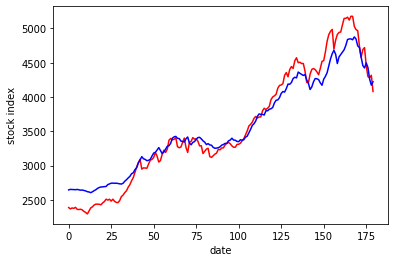

In [21]:
# 折线图展示
plt.figure()
data_list=[str(i) for i in range(0, 180)]
plt.plot(list(range(len(data_list[0:180]))), y_label[0:180], color='r')
plt.plot(list(range(len(data_list))), result, color='b')
plt.xlabel('date')
plt.ylabel('stock index')
#plt.plot(list(range(len(test_predict))), test_predict, color='b')
#plt.plot(list(range(len(test_y))), test_y, color='r')
plt.show()
